## Chapter3. word2vec
- 추론 기반 기법 word2vec simple version

### 1. 추론 기반 기법과 신경망
- 단어의 벡터 표현 방법은 지금도 활발히 연구. 그중 성공적인 기법이 `통계 기반 기법` 과 `추론 기반 기법`
- 배경에는 모두 분포 가설

1.1 통계 기반 기법의 문제점

- 통계 기반 기법에서는 주변 단어의 빈도를 기초로 단어를 표현
- 대규모 말뭉치를 다룰때, 어휘 쉬가 커지고 이러한 거대 행렬에 SVD 적용은 매우 어렵다
- 추론 기반 기법에서는 신경망을 이용하는 경우 미니배치로 학습하는 것이 일반적. 미니배치 학습에서는 신경망이 한번에 소량의 학습 샘플씩 반복해서 학습하며 가중치를 갱신


1.2 추론기반 기법 개요
- 추론이 주된 작업이며, 주변 단어(맥락)가 주어졌을 때 무슨 단어가 들어가는지를 추측하는 작업이다
- 추론 문제를 반복해서 풀며 단어의 출현 패턴을 학습. 모델은 맥락 정보를 입력받아 각 단어의 출현 확률을 출력
- 모델이 올바른 추측을 하도록 학습하고 그 학습의 결과로 단어의 분산 표현을 얻는 것


1.3 신경망에서의 단어 처리
- 원핫 one-hot 벡터 : 단어를 고정길이의 벡터로 변환하는 대표적인 방법. 원소중 하나만 1이고 나머지는 0
- 단어를 고정 길이 벡터로 변환하면 우리 신경망의 입력층은 뉴런의 수를 고정 할 수 있다
- 원핫 표현으로 된 단어 하나를 완전연결계층을 통해 변환(3장.편향 생략)
- 입력층 뉴런과 가중합이 은닉층의 뉴런이 된다

In [1]:
# 완전 연결층에 의한 변환. ID가 0인 단어 예시
import numpy as np

c = np.array([[1,0,0,0,0,0,0]])     # 입력
W = np.random.randn(7, 3)           # 가중치
h = np.matmul(c, W)                 # 중간노드

print(h)

[[ 1.83002824 -0.92094387 -1.28745632]]


In [2]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/common')
import numpy as np
from common.layers import MatMul

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-0.9922278  -0.54973838  0.0834649 ]]


### 2. 단순한 word2vec
- CBOW continuous bag-of-words 모델 과 skip-gram 모델

2.1 CBO 모델의 추론 정리
- 맥락으로부터 타깃을 추측하는 용도의 신경망. 맥락은 "you"와 "goodbye" 같은 단어들의 목록
- 입력층을 거쳐 출력층에 도달. 입력층에서 은닉층으로의 변환은 완전연결계층에 의해서 이루어진다. 
- 이때 완전연결계층의 가중치의 각 행이 해당 단어의 분산 표현이다. 학습을 진행할수록 맥락에서 출현하는 단어를 잘 추측하는 방향으로 분산 표현이 갱신됨
- 은닉층의 뉴런 수를 입력층의 뉴런 수보다 적게 하는것이 중요한 핵심이다. 
- 은닉층에 단어 예측에 필요한 정보를 간결하게 담게 되며, 결과적으로 밀집벡터 표현을 얻을 수 있다
- 계층 관점에서 가장 앞단에 MatMul 계층이 있고 이 두계층의 출력이 더해진 값에의평균이 은닉층 뉴런이 되며,은닉층 뉴런에 MatMul 계층이 다시 적용되며 점수 score가 출력된다

In [3]:
# CBOW 모델 추론처리 구현
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/common')
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
s = out_layer.forward(h)

print(s)

[[ 1.20074301 -0.34110393 -0.18240952 -0.68433601  0.61664803  1.21814822
   0.24327017]]


2.2 CBOW 모델의 학습

- 출력층에서 각 단어의 점수를 출력. 이 점수에 소프트맥스 함수를 적용하면 확률을 얻을수 있다.
- 이 확률은 맥락(전후 단어)이 주어졌을 때 그 중앙에 어떤 단어가 출현하는 지를 나타냄
- CBOW 모델의 학습에서는 올바른 예측을 할 수 있도록 가중치를 조정하는 일을 한다
- CBOW 추론 처리 수행에 Softmax 계층과 Cross Entropy Error 계층을 추가(Softmax with Loss 계층)


2.3 word2vec의 가중치와 분산 표현
- word2vec에서 사용되는 신경망에는 입력 측 완전연결계층의 가중치와 출력 측 완전연결계층의 가중치 있다
- 입력 측 가중치는 각 행이 각 단어의 분산 표현에 해당, 출력 측 가중치는 단어의 분산 표현이 열방향으로 저장
- 최종적으로 이용하는 단어의 분산 표현은 어느 쪽 가중치를 선택하면 좋을까?
    - word2vec(특히 skip-gram 모델) 에서는 입력측의 가중치만 이용하는것이 가장 대중적인 선택.
    - 출력 측 가중치는 버리고 입력 측 가중치로 최종 단어의 분산표현으로 이용. word2vec와 비슷한 기법인 GloVe에서는 입출력 가중치를 더하기도 한다



### 3. 학습 데이터 준비

3.1 맥락과 타깃
- word2vec에서 이용하는 신경망의 입력은 맥락, 정답 레이블은 맥락에 둘러싸인 중앙의 단어 타깃.
- 결론은 신경망에 맥락을 입력했을때 타깃의 출현 확률을 높이는것이다.

In [4]:
# 말뭉치에서 맥락과 타깃을 만드는 함수 구현
# 2장 구현 preprocess() 함수 사용
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/common')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [5]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [6]:
# 맥락과 타깃 생성 함수
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [7]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts, '\n\n', target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]] 

 [1 2 3 4 1 5]


3.2 원핫 표현으로 변환
- convert_one_hot() 함수 사용

In [9]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/common')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

### 4. CBOW 모델 구현

In [11]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/common')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

# SimpleCBOW 클래스 초기화 메서드
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장
        self.word_vecs = W_in
    
    # 순전파 forward() 메서드
    def forward(self, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer
        return loss

    # 역전파 backward() 메서드
    def backward(self, dout=1):
        ds = self.loss_layer.backword(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

4.1 학습코드 구현

In [18]:
# matplotlib 한글 폰트 오류문제 해결
from matplotlib import font_manager, rc
font_path = "D:/대학원/22_Spring/파이썬프로그래밍_서찬웅/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

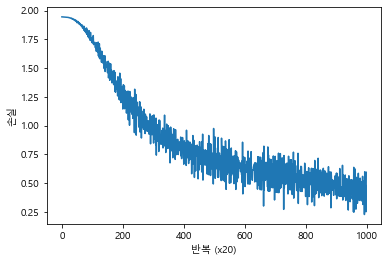

In [19]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/common')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [17]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-0.9676805   0.9616956   0.9468164   1.6809328  -0.94820726]
say [ 1.2500755  -0.18449402 -1.2404357   0.39477468  1.2444707 ]
goodbye [-1.0348278  1.0893415  1.0482988 -0.5370262 -1.0955328]
and [ 0.99415696  1.6955811  -0.97271436  1.4665786   0.9467396 ]
i [-1.0173295   1.0641036   1.0350597  -0.53584385 -1.0728623 ]
hello [-0.9845769   0.980549    0.95487744  1.6795491  -0.9758866 ]
. [ 1.1631908 -1.3897815 -1.1492103 -1.5005798  1.1135579]


### 5. word2vec 보충

5.1 CBOW 모델과 확률
- CBOW 모델은 맥락을 주면 타깃 단어가 출현할 확률을 출력
- CBOW : $P(w_t | w_{t-1}, w_{t+1}) \;\; L = -\cfrac{1}{T}\sum_{t=1}^{T}logP(w_t | w_{t-1}, w_{t+1})$

5.2 skip-gram 모델
- skip-gram 은 CBOW에서 다루는 맥락과 타깃을 역전시킨 모델
- skip-gram : $P(w_{t-1},w_{t+1}|w_t) = P(w_{t-1}|w_t)P(w_{t+1}|w_t)\;\; L = \cfrac{1}{T}\sum_{t=1}^{T}(logP(w_{t-1}|w_t)+logP(w_{t+1}|w_t))$

### 6. 정리

- 추론 기반 기법은 추측하는 것이 목적이며, 그 부산물로 단어의 분산 표현을 얻을 수 있다
- word2vec은 추론 기반 기법이며, 단순한 2층 신경망이다
- word2vec은 skip-gram 모델과 CBOW 모델을 제공한다
- CBOW 모델은 여러 단어(맥락)로부터 하나의 단어(타깃)를 추측한다
- 반대로 skip-gram 모델은 하나의 단어(타깃)로부터 다수의 단어(맥락)를 추측한다
- word2vec은 가중치를 다시 학습할 수 있으므로, 단어의 분산 표현 갱신이나 새로운 단어 추가를 효율적으로 수행할 수 있다